In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import uuid
import re

from datetime import datetime, timezone

%matplotlib inline
# %matplotlib ipympl

# QC and cleaning of downloaded river discharge data

In this notebook, we read in raw discharge data downloaded from NVE in notebook q1_get_daily_NVE_data, and then:
- Do some quick plots
- Check for NaNs. For the one river that has NaNs (Drammenselva), we patch values from Mjøndalsbru with data from further upstream (after making a quick correction of the upstream data).
- Tidy up the formatting and write only the relevant Q data to csv (i.e. dropping the usual additional NVE non-data columns).

The result is daily mean discharge data estimates from 1990 to present for all three rivers. Data pre-2005 is more uncertain for Drammenselva, where it is scaled data from Døvikfoss further upstream.

## 0. User inputs

In [2]:
# Filepaths
raw_data_folder = r'../../data/river/discharge/raw'

# Station coords 
station_coords = {
    "15.61.0": {"latitude": 59.18906, "longitude": 9.99414}, 
    "12.534.0": {"latitude": 59.75292, "longitude": 10.00727}, 
    "2.605.0": {"latitude": 59.63733, "longitude": 11.15354},
}

# Replacement map
replacements = str.maketrans({
    "æ": "ae", "ø": "o", "å": "a"
})

# Comment for selected station
discharge_comments = {
    "Drammenselva": (
        "Discharge data for the Drammenselva river was compiled using measurements from two stations: "
        "Mjøndalen bru (station ID: 12.534.0) and Døvikfoss (station ID: 12.285.0). "
        "The primary time series is based on the Mjøndalen bru station. "
        "However, periods with missing data in this series were filled using data from Døvikfoss, "
        "adjusted using a mean-based scaling factor to account for systematic differences between the two stations. "
        "This patching approach was applied to improve the continuity and completeness of the Drammenselva discharge time series."
    )
}

# Metadata
global_metadata_config = {
    "naming_authority": "no.niva",
    "project": "AquaINFRA",
    "iso_topic_category": "inlandWaters",
    "featureType": "timeSeries",
    "spatial_representation": "point",
    "creator_type": "institution",
    "creator_institution": "Norwegian Institute for Water Research (NIVA)",
    "institution": "Norwegian Institute for Water Research (NIVA)",
    "institution_short_name": "NIVA",
    "creator_name": "Leah Jackson-Blake",
    "creator_email": "leah.jackson-blake@niva.no",
    "creator_url": "https://www.niva.no/en/employees/leah-amber-jackson-blake?result_count=68",
    "data_owner": "Norwegian Institute for Water Research",
    "source": "NVE HydAPI (https://hydapi.nve.no/). Original license: NLOD 2.0 (https://data.norge.no/nlod/en/2.0)",
    "processing_level": "Cleaned and harmonized daily discharge",
    "Conventions": "CF-1.7, ACDD-1.3",
    "publisher_name": "Norwegian Institute for Water Research",
    "publisher_email": "miljoinformatikk@niva.no",
    "publisher_institution": "Norwegian Institute for Water Research",
    "publisher_url": "https://niva.no",
    "license": "http://spdx.org/licenses/CC-BY-4.0(CC-BY-4.0)",
    "keywords": "GCMDSK:EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SURFACE WATER > SURFACE WATER PROCESSES/MEASUREMENTS > DISCHARGE/FLOW, GCMDLOC:CONTINENT > EUROPE > NORWAY",
    "keywords_vocabulary": "GCMDSK:GCMD Science Keywords, GCMDLOC:GCMD Locations",
    "history": (
        "2024-08-28 - Data retrieved from NVE HydAPI with 1440-minute resolution.\n"
        "Data filtered to start from 1990-01-01.\n"
        "Timestamps normalized to daily frequency and made timezone-naive.\n"
        "Discharge values rounded to 3 decimal places.\n"
    )
}

processed_namespace_uuid = uuid.uuid5(uuid.NAMESPACE_DNS, "aquainfra.niva.no")

# Where to save
out_data_folder = r'../../data/river/discharge/clean'
os.makedirs(out_data_folder, exist_ok=True)

fig_folder = r'../../figures/discharge'
os.makedirs(fig_folder, exist_ok=True)

## 1. Read in data

Data download done in notebook q1_get_daily_NVE_data

In [3]:
data_dict = {}  # key: (river, station_name, station_id)

for file in glob.glob(os.path.join(raw_data_folder, "Q_daily-mean_*.nc")):
    
    # Extract river, station_name, and station_id from filename
    filename = os.path.basename(file)
    parts = filename.split('_')
    river = parts[2].translate(replacements)
    station_name = parts[3].translate(replacements)
    station_id = parts[4]

    ds = xr.open_dataset(file)
    df = ds.to_dataframe()

    if "station_name" in df.columns:
        df["station_name"] = df["station_name"].str.translate(replacements)
    if "river" in df.columns:
        df["river"] = df["river"].str.translate(replacements)
        
    data_dict[(river, station_name, station_id)] = df

In [4]:
# Make a little site metadata df for plot naming later
site_df = pd.DataFrame(data_dict.keys(), columns=['river', 'station_name', 'station_id'])
site_df

,river,station_name,station_id
0,Drammenselva,Dovikfoss,12.285.0
1,Drammenselva,Mjondalen bru,12.534.0
2,Glomma,Solbergfoss,2.605.0
3,Numedalslagen,Holmfoss,15.61.0


## 2. Quick plots

### Whole series after 1990

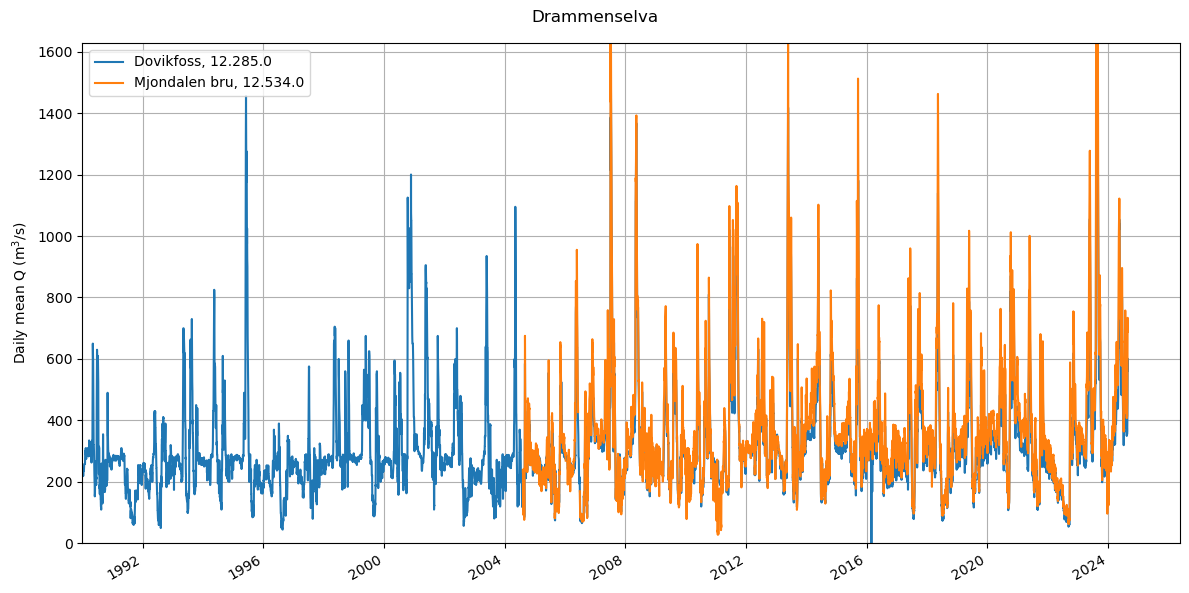

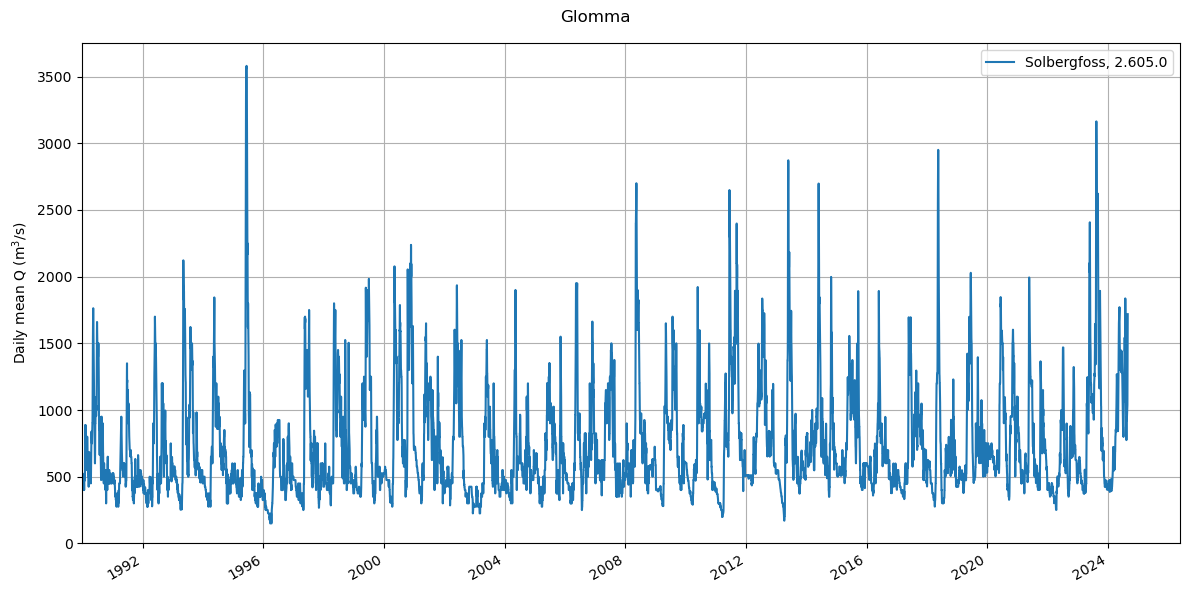

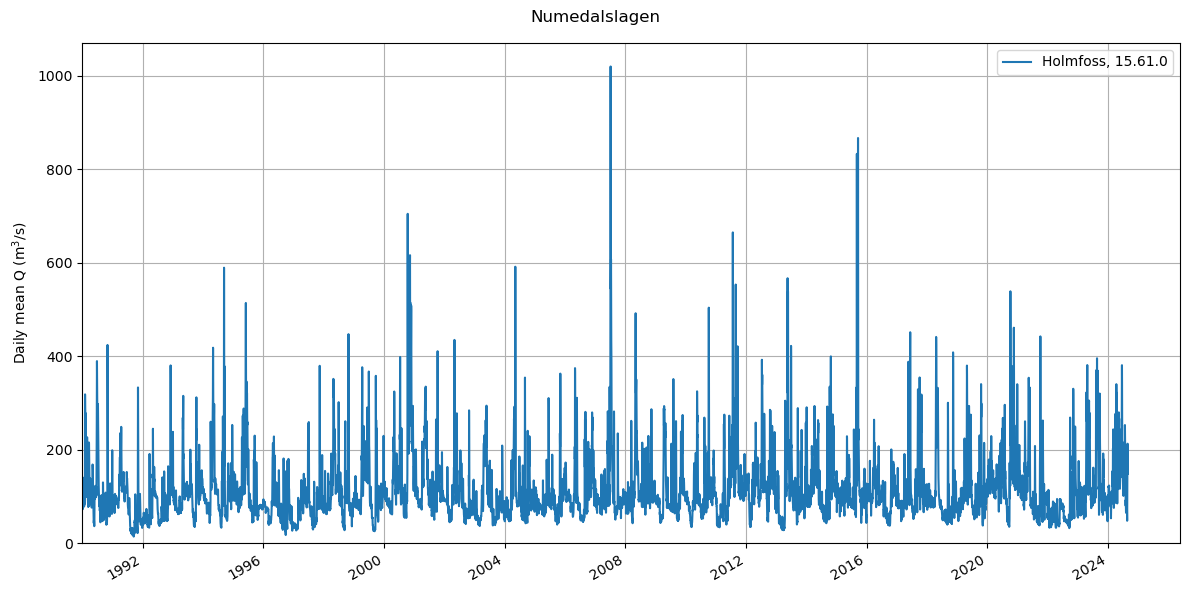

In [5]:
riv_li = site_df['river'].unique()

# for river, stn_dict in stn_id_name_dict.items():
#     for station_id, station_name in stn_dict.items():

for river in riv_li:
    ax = plt.figure(figsize=(12, 6)).add_subplot(111)

    riv_df = site_df.loc[site_df['river'] == river]

    for station_name in riv_df['station_name']:
        station_id = riv_df.loc[riv_df['station_name'] == station_name, 'station_id'].values[0]

        df = data_dict[(river, station_name, station_id)].copy()

        # Only plot data from 1990 onwards
        df.loc[f"1990-01-01":, 'discharge'].plot(ax=ax, label=f"{station_name}, {station_id}")
        plt.grid(True)
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin="1989-12-31")
        plt.xlabel('')
        plt.ylabel('Daily mean Q (m$^3$/s)')
        plt.legend()

    plt.suptitle(river)
    plt.tight_layout()
    fpath = os.path.join(fig_folder, f"Q_raw_timeseries_1990_onwards_{river}.png")
    plt.savefig(fpath)
    plt.show()

### Plot year by year

In [6]:
def plot_year_by_year(start_year, end_year, df):
    yr_list = list(range(start_year, end_year+1))
    n_yrs = len(yr_list)
    fig, axs = plt.subplots(n_yrs, 1, figsize=(10, n_yrs * 2.5), sharey=True)

    for i, year in enumerate(yr_list):
        df['discharge'].loc[f'{year}-01-01':f'{year}-12-31'].plot(ax=axs[i])
        axs[i].grid(True)
        # Format x-axis to show month only (year is in the subplot title)
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        # Sort out tick labels (unrotate and re-centre)
        axs[i].tick_params(axis='x', rotation=0)
        for label in axs[i].get_xticklabels():
            label.set_ha('center')

        axs[i].set_xlabel('')
        axs[i].set_ylabel('Q (m$^3$/s)')
        axs[i].set_title(year)

    plt.suptitle(df['station_name'].iloc[0])

    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust the rect parameter to add padding
    plt.show()

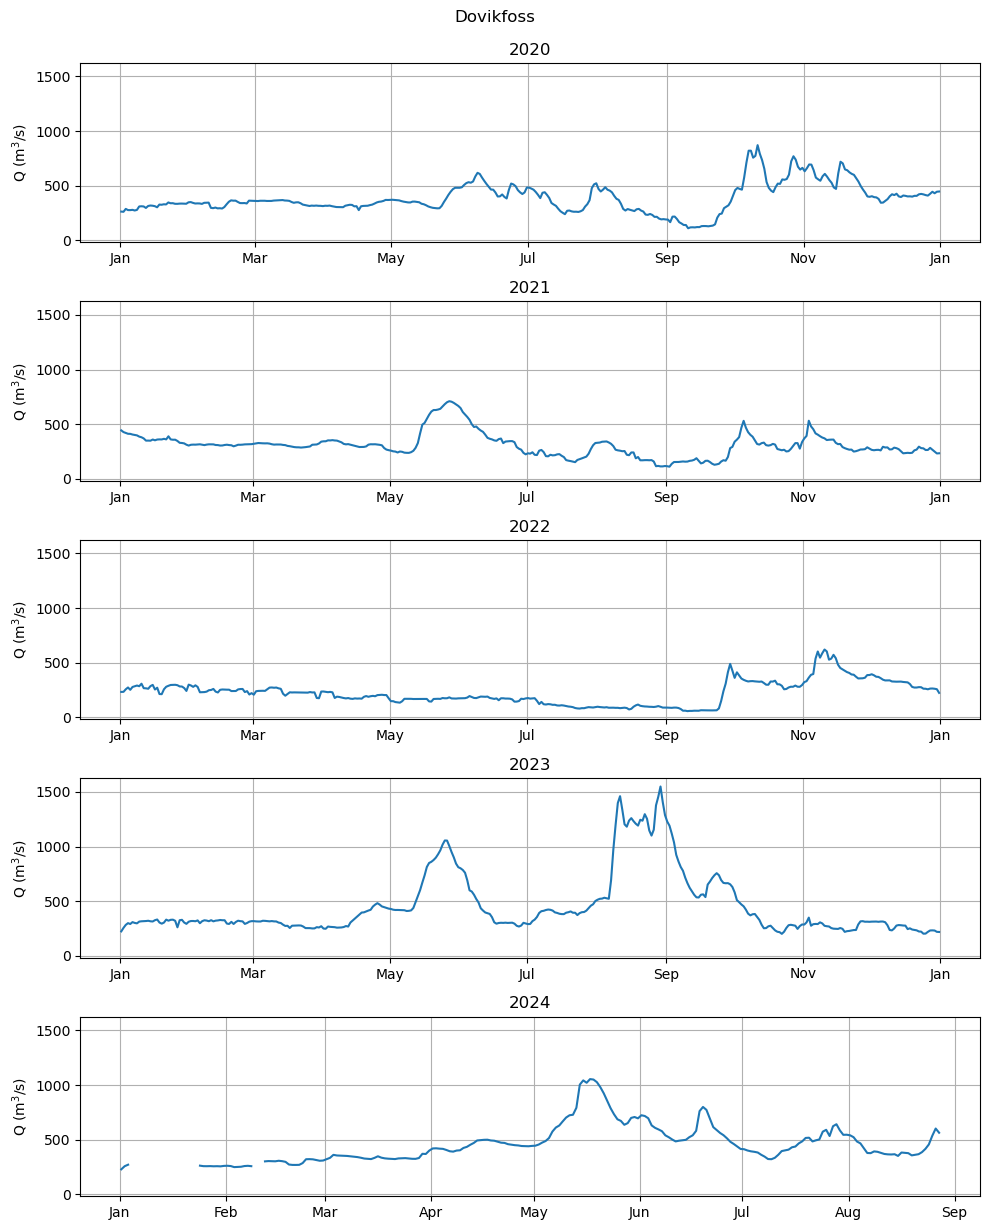

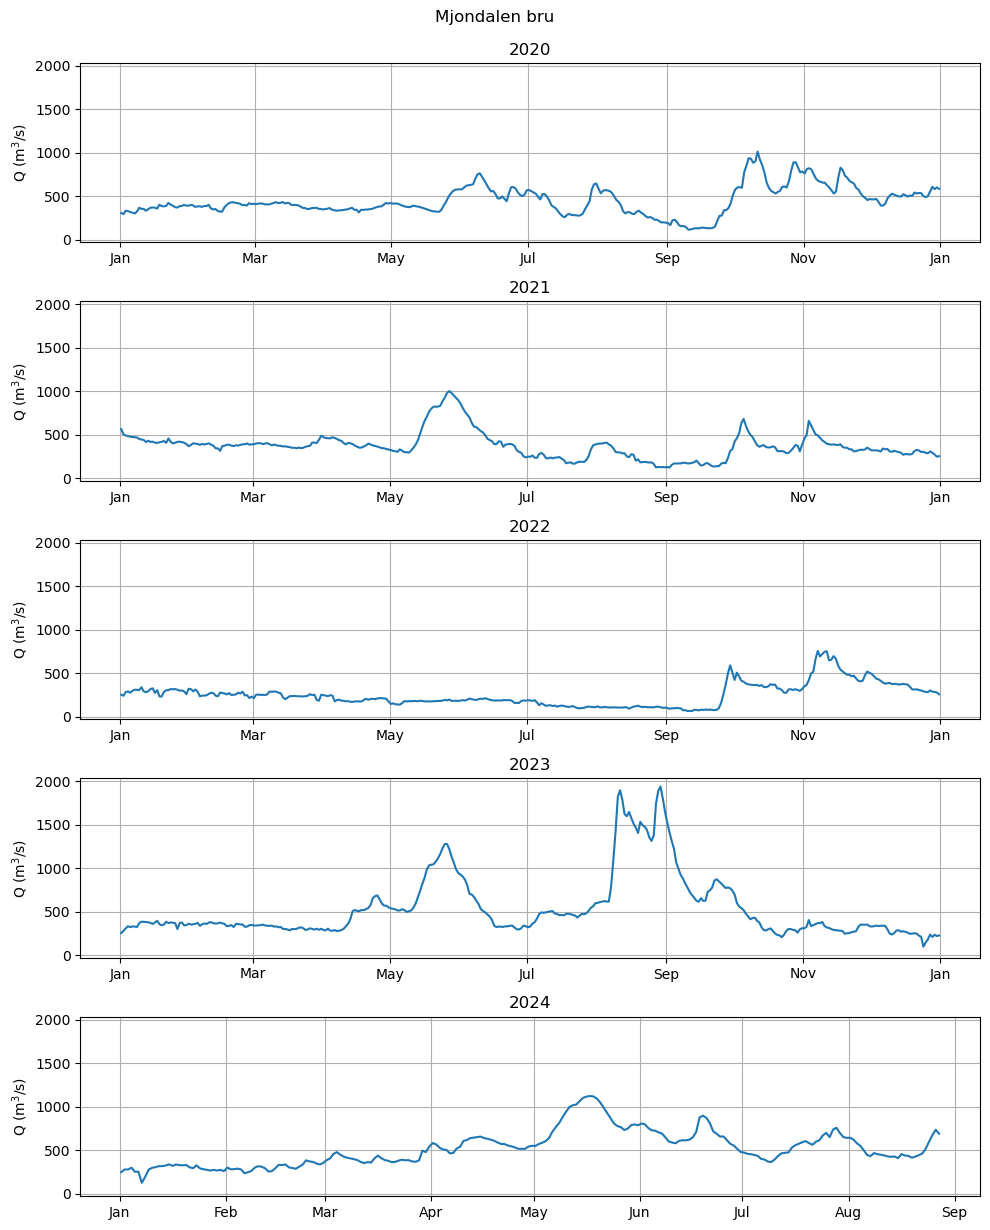

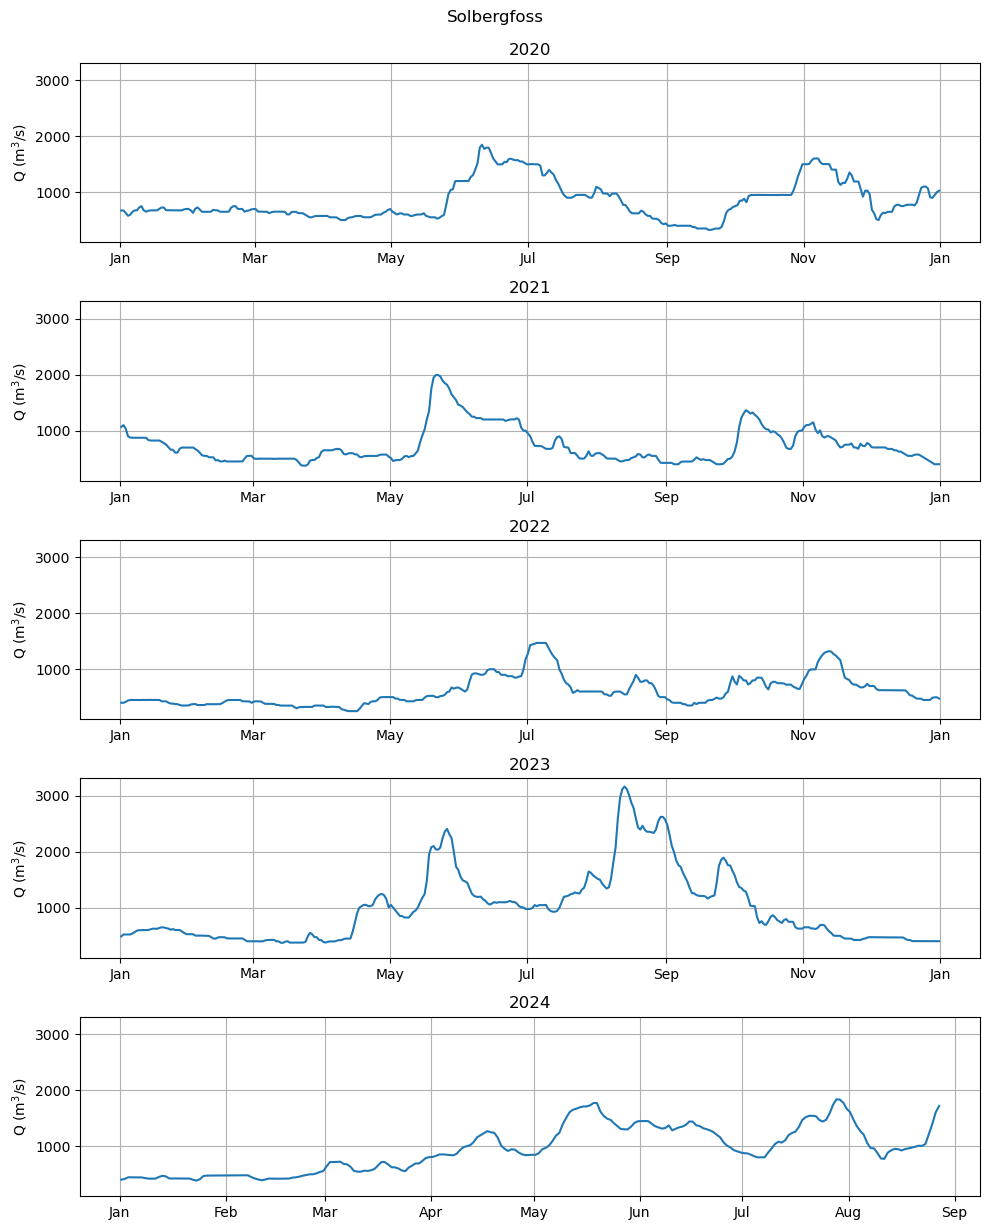

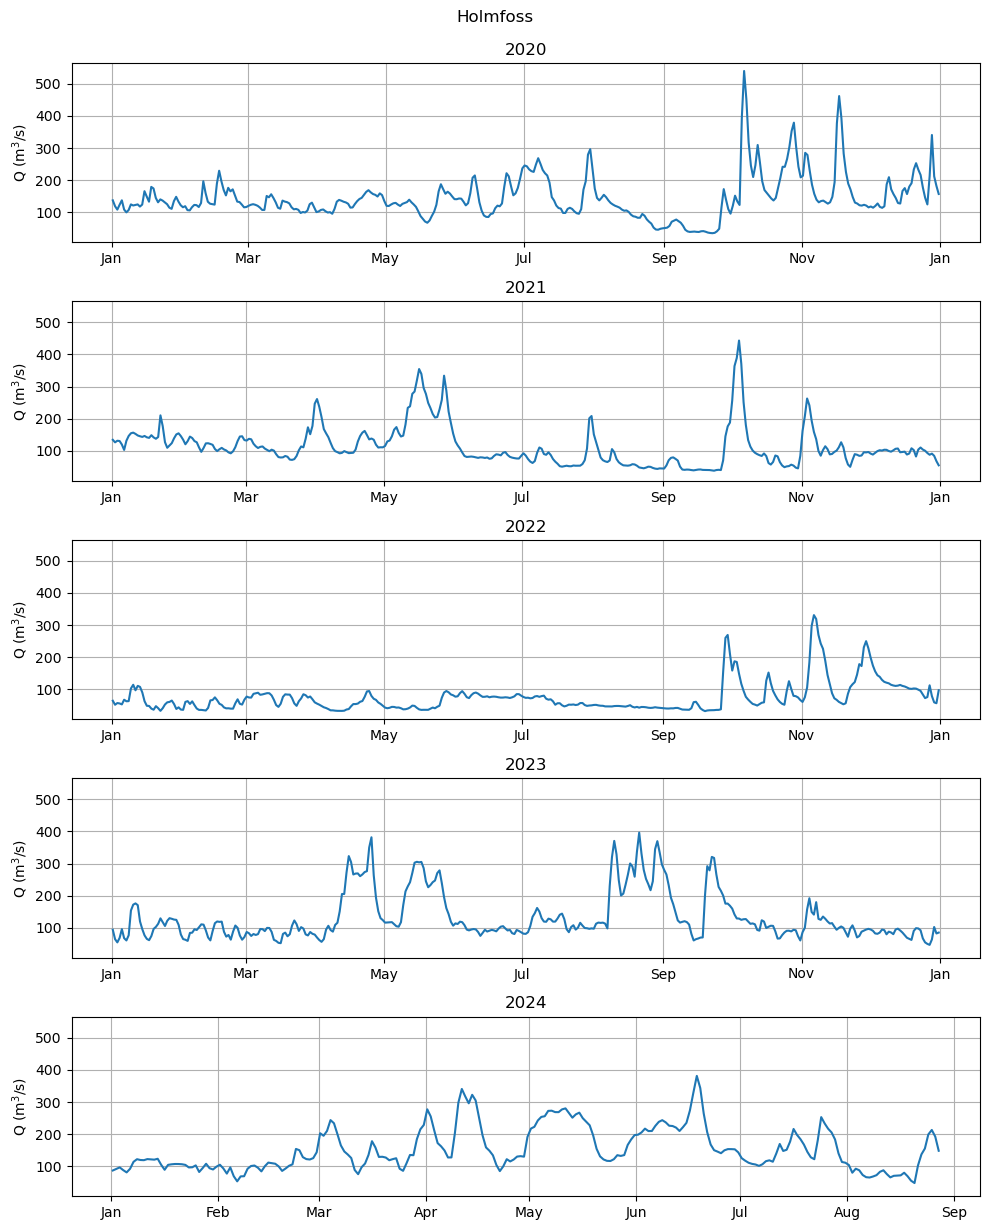

In [7]:
for key in data_dict.keys():
    df = data_dict[key]
    plot_year_by_year(2020, 2024, df)

## 3. Fill NaNs

To estimate freshwater fluxes to the Oslofjord we need complete time series of freshwater flows. Here, we check for NaNs, and then if any are present fill them by patching or interpolating.

In [8]:
# Check for NaNs
for key, df in data_dict.items():
    print(key)
    # Remove data pre-1990
    df = df.loc["1990":, :]

    # Convert to daily frequency (if isn't already)
    df = df.asfreq('D')

    # Count number of NaNs since 1990
    nan_count = df['discharge'].isna().sum()
    print(f"Number of NaNs: {nan_count}")

    # Calculate the number of data gaps
    df['gap_start'] = df['discharge'].notna().astype(int).diff().fillna(0) == -1
    num_gaps = df['gap_start'].sum()
    print(f"Number of data gaps: {num_gaps}")

    # Calculate the length of the longest data gap (in days)
    df['gap'] = df['discharge'].isna().astype(int).groupby(df['discharge'].notna().astype(int).cumsum()).cumsum()
    longest_gap = df['gap'].max()
    print(f"Longest data gap: {longest_gap} days\n")

('Drammenselva', 'Dovikfoss', '12.285.0')
Number of NaNs: 23
Number of data gaps: 2
Longest data gap: 20 days

('Drammenselva', 'Mjondalen bru', '12.534.0')
Number of NaNs: 59
Number of data gaps: 7
Longest data gap: 20 days

('Glomma', 'Solbergfoss', '2.605.0')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days

('Numedalslagen', 'Holmfoss', '15.61.0')
Number of NaNs: 0
Number of data gaps: 0
Longest data gap: 0 days



Numedalslågen and Glomma are good. Drammenselva discharge data has more issues. Decide to patch Mjøndalen bru data gaps with values from Døvikfoss. First, apply a correction to Døvikfoss discharge.

In [9]:
# Remove NaNs in Drammenselva discharge data

primary_series = data_dict[('Drammenselva', 'Mjondalen bru', '12.534.0')]['discharge'].copy().loc['1990':]
secondary_series = data_dict[('Drammenselva', 'Dovikfoss', '12.285.0')]['discharge'].copy().loc['1990':]

# Ensure all timestamps are timezone-naive and drop time info
primary_series.index = primary_series.index.tz_localize(None).normalize()
secondary_series.index = secondary_series.index.tz_localize(None).normalize()

# Check how many NaNs we start with in the original Mjøndalen bru data
nan_count = primary_series.isna().sum()
print(f"Original number of NaNs: {nan_count}")

# Now extend Mjøndalen bru data back to 1990, inserting NaNs
start_date = '1990-01-01'
# Insert NaN at the start date if it's not already in the index
if start_date not in primary_series.index:
    primary_series.loc[start_date] = np.nan
primary_series = primary_series.asfreq('D')

# Identify gaps in the primary series
gaps = primary_series[primary_series.isna()]

# Correct for systematic differences
# For simplicity, assume a linear relationship between the two series
common_dates = primary_series.dropna().index.intersection(secondary_series.dropna().index)
correction_factor = primary_series.loc[common_dates].mean() / secondary_series.loc[common_dates].mean()
print(f"Mjondalen mean discharge / Dovikfoss mean discharge = {correction_factor}")
corrected_secondary_series = secondary_series * correction_factor

# Patch the gaps in the primary series using the corrected secondary series
primary_series.loc[gaps.index] = corrected_secondary_series.loc[gaps.index]

# Check how many NaNs are left
nan_count = primary_series.isna().sum()
print(f"Number of NaNs: {nan_count}")

Original number of NaNs: 59
Mjondalen mean discharge / Dovikfoss mean discharge = 1.116803914668843
Number of NaNs: 0


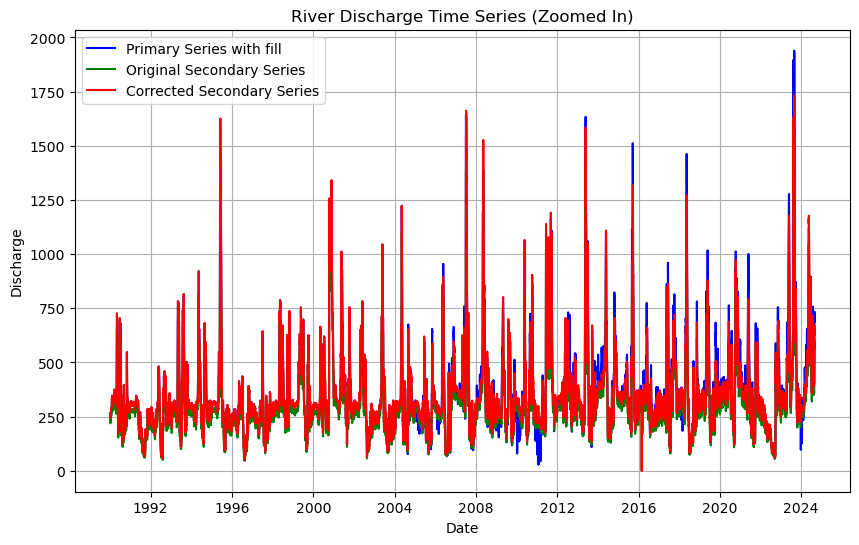

In [10]:
# Plot to check it's working: Whole series
plt.figure(figsize=(10, 6))
plt.plot(primary_series.index, primary_series, label='Primary Series with fill', color='blue')
plt.plot(secondary_series.index, secondary_series, label='Original Secondary Series', color='green')
plt.plot(corrected_secondary_series.index, corrected_secondary_series, label='Corrected Secondary Series', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('River Discharge Time Series (Zoomed In)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

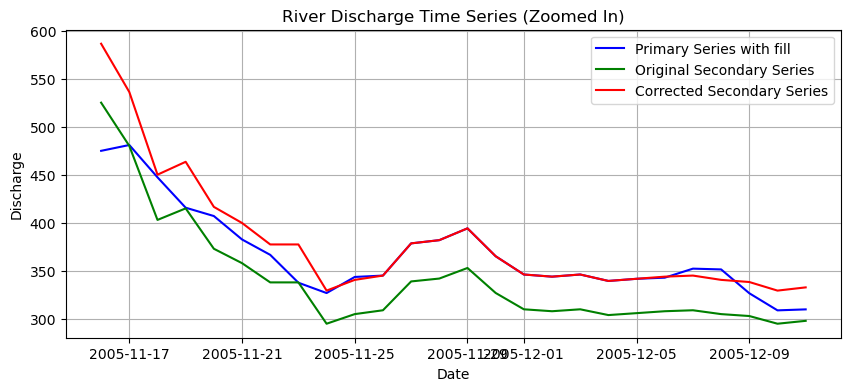

In [11]:
# Plot to check it's working: Zoom in on a period with gaps

# Identify a period with gaps in the primary series
gap_period_start = gaps['2005':].index[0] - pd.Timedelta(days=10)
gap_period_end = gaps['2005':].index[0] + pd.Timedelta(days=15)

# Filter the data for the identified period
primary_zoomed = primary_series.loc[gap_period_start:gap_period_end]
secondary_zoomed = secondary_series.loc[gap_period_start:gap_period_end]
corrected_secondary_zoomed = corrected_secondary_series.loc[gap_period_start:gap_period_end]

# Plot the zoomed data
plt.figure(figsize=(10, 4))
plt.plot(primary_zoomed.index, primary_zoomed, label='Primary Series with fill', color='blue')
plt.plot(secondary_zoomed.index, secondary_zoomed, label='Original Secondary Series', color='green')
plt.plot(corrected_secondary_zoomed.index, corrected_secondary_zoomed, label='Corrected Secondary Series', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('River Discharge Time Series (Zoomed In)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## 4. Clean and write to netcdf

In [12]:
def sanitize_filename_part(s):
    # Replace any character that is not a letter, digit, or underscore with an underscore
    return re.sub(r"[^\w]", "_", s)

for key in data_dict.keys():
    river, site_name, site_id = key

    if site_name == "Dovikfoss":
        continue

    # Generate UUID for this dataset
    unique_string = f"discharge_cleaned_{river}_{site_id}"
    dataset_uuid = uuid.uuid5(processed_namespace_uuid, unique_string)
    unique_id = f"no.niva:{dataset_uuid}"

    # Select and clean time series
    if river == "Drammenselva":
        q_s = primary_series.copy()
    else:
        q_s = data_dict[key]['discharge'].copy()

    q_s.index = q_s.index.normalize().tz_localize(None)
    q_s = q_s.loc["1990":]
    q_s.index.name = 'time'
    q_s = q_s.round(3)

    # Convert Series to xarray Dataset
    q_s.name = "discharge"
    ds = q_s.to_xarray().to_dataset()
    
    # Time coordinate CF attribute
    if "time" in ds.coords:
        ds["time"].attrs["standard_name"] = "time"

    # Add discharge variable attributes
    ds["discharge"].attrs.update({
        "units": "m3 s-1",
        "long_name": "Daily mean river discharge"
    })

    # Add optional description for specific rivers
    if river in discharge_comments:
        ds["discharge"].attrs["description"] = discharge_comments[river]

    # Add coordinates
    coords = station_coords.get(site_id, {"latitude": np.nan, "longitude": np.nan})
    lat = float(coords["latitude"])
    lon = float(coords["longitude"])
    ds = ds.assign_coords(
        latitude=xr.DataArray(lat, dims=(), attrs={
            "standard_name": "latitude", "long_name": "Latitude", "units": "degrees_north"
        }),
        longitude=xr.DataArray(lon, dims=(), attrs={
            "standard_name": "longitude", "long_name": "Longitude", "units": "degrees_east"
        }),
    ).set_coords(["latitude", "longitude"])

    # Add scalar station info
    ds["station_id"] = xr.DataArray(site_id, dims=())
    ds["station_name"] = xr.DataArray(site_name, dims=(), attrs={
        "cf_role": "timeseries_id",
        "comment": (
            f"Norwegian letters have been replaced with ASCII equivalents."
        )
    })

    # Global metadata (extend this as needed)
    metadata = global_metadata_config.copy()
    metadata.update({
        "id": unique_id,
        "title": f"Cleaned river discharge at station {site_name}",
        "title_no": f"Renset vannføring ved stasjon {site_name}",
        "summary": (
            f"Cleaned daily discharge time series from NVE HydAPI at station {site_name} "
            f"(code: {site_id}) on river {river}. Values from 1990 onward are included."
        ),
        "summary_no": (
            f"Renset daglig vannføringsdataserie fra NVE HydAPI ved stasjon {site_name} "
            f"(kode: {site_id}) i vassdraget {river}. Kun verdier etter 1990 er inkludert."
        ),
        "date_created": "2025-07-09T11:44:33Z",
        "time_coverage_start": str(q_s.index.min().date()),
        "time_coverage_end": str(q_s.index.max().date()),
        "geospatial_lat_min": lat,
        "geospatial_lat_max": lat,
        "geospatial_lon_min": lon,
        "geospatial_lon_max": lon,
    })
    ds.attrs.update(metadata)

    # Save NetCDF
    river = sanitize_filename_part(river)
    site_name = sanitize_filename_part(site_name)
    site_id = sanitize_filename_part(site_id)
        
    fname = f"Q_daily_mean_{river}_{site_name}_{site_id}_cleaned.nc"
    ds.to_netcdf(
        os.path.join(out_data_folder, fname),
        encoding={
            "time": {
                "dtype": "int32",
                "units": "days since 1970-01-01",
                "calendar": "standard"
            }
        }

    )

    print(f"Saved: {fname}")

Saved: Q_daily_mean_Drammenselva_Mjondalen_bru_12_534_0_cleaned.nc
Saved: Q_daily_mean_Glomma_Solbergfoss_2_605_0_cleaned.nc
Saved: Q_daily_mean_Numedalslagen_Holmfoss_15_61_0_cleaned.nc
